In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37663")
client

In [ ]:
client.restart()

In [ ]:
import numpy as np
import xarray as xr
import zarr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
from rechunker import rechunk
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ddir = '/tank/chaocean/'
topog = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [ ]:
grav = 9.81
Nyears = 50
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = 25
yend = 50
dnf = 2160
nfile = 73
xchunk = 100
ychunk = 101
schunk = 5
tchunk = 73
t_of_interest = 1

In [ ]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1967)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1421280,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                          YG=slice(ystart-12**-1,yend+2*12**-1)
                         ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                               'YC':ychunk,'YG':ychunk})

In [ ]:
years = np.arange(1963,2013,dtype=int)
ntimes = np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile)
# dd = 11
yystart = 0
print(years[yystart],ntimes[yystart])

In [ ]:
imemb = 0

yy = yystart
for year in years[yystart:]:

    for itime in ntimes[yy]:

        if itime == ntimes[yy,0]:
            ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs/run%4d/%010d/' 
                                       % (imemb,year,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                   )
        else:
            tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs/run%4d/%010d/' 
                                        % (imemb,year,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                    )
            ds2 = xr.concat([ds2,tmp2], 'time')
            tmp2.close()
            
    try:
        del ds2['dzetaF'].encoding['chunks']
        del ds2['dzetaFy'].encoding['chunks']
        del ds2['dzetaFx'].encoding['chunks']
        del ds2['zdz'].encoding['chunks']
        del ds2['zydz'].encoding['chunks']
        del ds2['zxdz'].encoding['chunks']
    except:
        pass
    
    if len(ds2.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
        
    ds2.chunk({'time':tchunk,'YC':ychunk,'YG':ychunk,
               'delta_outer':schunk,'deltax_outer':schunk,'deltay_outer':schunk}
             ).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                       % (imemb,year)), mode='w')
    if yy == yystart:
        print(ds2)
    ds2.close()
        
    print(year)
    yy += 1

In [ ]:
imemb = 0

for year in years:
    
    if year == years[0]:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
#         print(tmp2.time)
#         ds2 = xr.concat([ds2,tmp2], 'time')
        ds2 = xr.concat([ds2,tmp2], 'Nyear')
        tmp2.close()
    
print(ds2)

In [8]:
dyy = 10
n10 = 0
yy = int(n10*dyy)
imemb = 0
for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
    
    if (yy - dyy+1) % dyy == 0:
#         print(ds2)
        tmp1 = ds2.dzetaF.sum('Nyr',skipna=True) 
        tmp2 = ds2.dzetaFx.sum('Nyr',skipna=True) 
        tmp3 = ds2.dzetaFy.sum('Nyr',skipna=True)

        dsave = tmp1.to_dataset(name='dzeta')
        dsave['dzetax'] = tmp2
        dsave['dzetay'] = tmp3
        try:
            del dsave['dzeta'].encoding['chunks']
            del dsave['dzetax'].encoding['chunks']
            del dsave['dzetay'].encoding['chunks']
        except:
            pass
        print(dsave)
        dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/dZs_summed/ann/%02d-%02d' 
                                                      % (imemb,yy-dyy+1,yy)), mode='w')
        ds2.close()
        dsave.close()
    print(year)
    yy += 1

1963
1964
1965
1966
1967
1968
1969
1970
1971
<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    dzeta         (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    dzetax        (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5)

In [9]:
dyy = 10
n10 = 0
yy = int(n10*dyy)
imemb = 0
for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
    
    if (yy - dyy+1) % dyy == 0:
#         print(ds2)
        tmp4 = (ds2.zdz*ds2.dzetaF**-1).sum('Nyr',skipna=True)
        tmp5 = (ds2.zxdz*ds2.dzetaFx**-1).sum('Nyr',skipna=True)
        tmp6 = (ds2.zydz*ds2.dzetaFy**-1).sum('Nyr',skipna=True)

        dsave = tmp4.to_dataset(name='zeta')
        dsave['zetax'] = tmp5
        dsave['zetay'] = tmp6
        try:
            del dsave['zeta'].encoding['chunks']
            del dsave['zetax'].encoding['chunks']
            del dsave['zetay'].encoding['chunks']
        except:
            pass
        dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_summed/ann/%02d-%02d' 
                                                      % (imemb,yy-dyy+1,yy)), mode='w')
        print(dsave)
        ds2.close()
        dsave.close()
    print(year)
    yy += 1

1963
1964
1965
1966
1967
1968
1969
1970
1971
<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    zeta          (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    zetax         (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5)

In [15]:
dyy = 10

for yy in range(0,Nyears,dyy):
    if yy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/dZs_summed/ann/%02d-%02d/' 
                                   % (imemb,yy,yy+dyy-1))
                          )
        ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_summed/ann/%02d-%02d/' 
                                   % (imemb,yy,yy+dyy-1))
                          )
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/dZs_summed/ann/%02d-%02d/' 
                                    % (imemb,yy,yy+dyy-1))
                           )
        ds2 = xr.concat([ds2,tmp2], 'Ny')
        tmp2.close()
        tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_summed/ann/%02d-%02d/' 
                                    % (imemb,yy,yy+dyy-1))
                           )
        ds3 = xr.concat([ds3,tmp3], 'Ny')
        tmp3.close()

print(ds2)
        
dzetaFb = ds2.dzeta.sum('Ny',skipna=True) / Nyears
dzetaFxb = ds2.dzetax.sum('Ny',skipna=True) / Nyears
dzetaFyb = ds2.dzetay.sum('Ny',skipna=True) / Nyears
zetab = ds3.zeta.sum('Ny',skipna=True) / Nyears
zetaxb = ds3.zetax.sum('Ny',skipna=True) / Nyears
zetayb = ds3.zetay.sum('Ny',skipna=True) / Nyears

dsave = dzetaFb.to_dataset(name='dzetab')
dsave['dzetaxb'] = dzetaFxb
dsave['dzetayb'] = dzetaFyb
dsave['zetab'] = zetab
dsave['zetaxb'] = zetaxb
dsave['zetayb'] = zetayb
dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann' 
                                              % (imemb)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:       (Ny: 5, XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: Ny, time
Data variables:
    dzeta         (Ny, time, YC, XC, delta_outer) float32 dask.array<chunksize=(1, 73, 101, 100, 5), meta=np.ndarray>
    dzetax        (Ny, time, YC, XG, deltax_outer) float32 dask.array<chunksize=(1, 73, 101, 100, 5), meta=np.ndarray>
 

In [22]:
# yystart = 0
imemb = 0

for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    ds2.coords['seas'] = ('time',np.concatenate((np.repeat(np.arange(4),18), np.array([0]))))
    
    dzetaF = ds2.dzetaF.groupby('seas').sum('time',skipna=True) 
    dzetaFx = ds2.dzetaFx.groupby('seas').sum('time',skipna=True)
    dzetaFy = ds2.dzetaFy.groupby('seas').sum('time',skipna=True)
    zeta = (ds2.zdz*ds2.dzetaF**-1).groupby('seas').sum('time',skipna=True)
    zetax = (ds2.zxdz*ds2.dzetaFx**-1).groupby('seas').sum('time',skipna=True)
    zetay = (ds2.zydz*ds2.dzetaFy**-1).groupby('seas').sum('time',skipna=True)
    
    dsave = dzetaF.to_dataset(name='dzetaF')
    dsave['dzetaFx'] = dzetaFx
    dsave['dzetaFy'] = dzetaFy
    dsave['zeta'] = zeta
    dsave['zetay'] = zetay
    dsave['zetax'] = zetax
    try:
        del dsave['dzeta'].encoding['chunks']
        del dsave['dzetax'].encoding['chunks']
        del dsave['dzetay'].encoding['chunks']
        del dsave['zeta'].encoding['chunks']
        del dsave['zetax'].encoding['chunks']
        del dsave['zetay'].encoding['chunks']
    except:
        pass
    dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_summed/seas/run%4d' 
                                                  % (imemb,year)), mode='w')
    if year == years[yystart]:
        print(dsave)
    print(year)
    dsave.close()
    ds2.close()

/tank/users/tuchida/miniconda3/envs/dimage/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/users/tuchida/miniconda3/envs/dimage/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return 

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, seas: 4)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * seas          (seas) int64 0 1 2 3
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Data variables:
    dzetaF        (seas, YC, XC, delta_outer) float32 dask.array<chunksize=(1, 101, 200, 5), meta=np.ndarray>
    dzetaFx       (seas, YC, XG, deltax_outer) float32 dask.array<chunksize=(1, 101, 200, 5), meta=np.ndarray>
    dzetaFy       (seas, YG

/tank/users/tuchida/miniconda3/envs/dimage/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/users/tuchida/miniconda3/envs/dimage/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return 

OSError: [Errno 5] Input/output error: '/tank/tdgs/tuchida/TWA/5Dave/memb00/Zs_rechunked/run1968/dzetaF/.zarray'

In [10]:
# seas = np.concatenate((np.repeat(np.arange(4),18), np.array([0])))
# ds2.coords['seas'] = ('time',np.tile(seas,50))


Nt = 3650
imemb = 0
yystart = 0

for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/dZs_summed/clim/run%4d/' 
                               % (imemb,year))
                      )
    
    if year == years[0]:
        dzetab = ds2.dzetab
        dzetaxb = ds2.dzetaxb
        dzetayb = ds2.dzetayb

    else:
        dzetab = xr.concat([dzetab,ds2.dzetab], 'time')
        dzetaxb = xr.concat([dzetaxb,ds2.dzetaxb], 'time')
        dzetayb = xr.concat([dzetayb,ds2.dzetayb], 'time')
    
    ds2.close()

dzetab = dzetab.sum('time',skipna=True) / Nt 
dzetaxb = dzetaxb.sum('time',skipna=True) / Nt 
dzetayb = dzetayb.sum('time',skipna=True) / Nt 

dsave = dzetaFb.to_dataset(name='dzetab')
dsave['dzetaxb'] = dzetaFxb
dsave['dzetayb'] = dzetaFyb
dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/dZb/clim' 
                                              % (imemb)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Data variables:
    dzetab        (YC, XC, delta_outer) float32 dask.array<chunksize=(101, 200, 5), meta=np.ndarray>
    dzetaxb       (YC, XG, deltax_outer) float32 dask.array<chunksize=(101, 200, 5), meta=np.ndarray>
    dzetayb       (YG, XC, deltay_outer) float32 dask.array<chunksize=(101, 200, 5), meta=np.

In [9]:
# seas = np.concatenate((np.repeat(np.arange(4),18), np.array([0])))
# ds2.coords['seas'] = ('time',np.tile(seas,50))

Nseas = xr.DataArray(np.array([19,18,18,18]), dims='seas',
                     coords={'seas':np.arange(4)}
                    )
Nt = 3650
imemb = 0
yystart = 0

for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_summed/seas/run%4d/' 
                               % (imemb,year))
                      )
    
    if year == years[0]:
        dzetaF = ds2.dzetaF
        dzetaFx = ds2.dzetaFx
        dzetaFy = ds2.dzetaFy
        zeta = ds2.zeta
        zetax = ds2.zetax
        zetay = ds2.zetay
        print(ds2)
    else:
        dzetaF = xr.concat([dzetab,ds2.dzetaF], 'time')
        dzetaFx = xr.concat([dzetaxb,ds2.dzetaFx], 'time')
        dzetaFy = xr.concat([dzetayb,ds2.dzetaFy], 'time')
        zeta = xr.concat([zeta,ds2.zeta], 'time')
        zetax = xr.concat([zetax,ds2.zetax], 'time')
        zetay = xr.concat([zetay,ds2.zetay], 'time')
    
    ds2.close()

print(zeta)
dzetaFb = dzetaF.groupby('seas').sum('time',skipna=True) / Nseas
dzetaFxb = dzetaFx.groupby('seas').sum('time',skipna=True) / Nseas
dzetaFyb = dzetaFy.groupby('seas').sum('time',skipna=True) / Nseas
zetab = zeta.groupby('seas').sum('time',skipna=True) / Nseas
zetaxb = zetax.groupby('seas').sum('time',skipna=True) / Nseas
zetayb = zetay.groupby('seas').sum('time',skipna=True) / Nseas

dsave = dzetaFb.to_dataset(name='dzetab')
dsave['dzetaxb'] = dzetaFxb
dsave['dzetayb'] = dzetaFyb
dsave['zetab'] = zetab
dsave['zetayb'] = zetay
dsave['zetaxb'] = zetax
dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/seas' 
                                              % (imemb)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Data variables:
    zetab         (YC, XC, delta_outer) float32 dask.array<chunksize=(101, 200, 5), meta=np.ndarray>
    zetaxb        (YC, XG, deltax_outer) float32 dask.array<chunksize=(101, 200, 5), meta=np.ndarray>
    zetayb        (YG, XC, deltay_outer) float32 dask.array<chunksize=(101, 200, 5), meta=np.

In [ ]:
yy = yystart
imemb = 0


for year in years[yystart:]:
    
    for itime in ntimes[yy]:
        
        if itime == ntimes[yy,0]:
            ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns/run%4d/%010d/' 
                                       % (imemb,year,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                   ).reset_coords(drop=True
                                                 ).chunk({'delta':schunk,
                                                          'deltay_outer':schunk,
                                                          'deltax_outer':schunk})
            ds4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi/run%4d/%010d/' 
                                       % (imemb,year,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                   ).reset_coords(drop=True
                                                 ).chunk({'delta':schunk,
                                                          'delta_outer':schunk})
        else:
            tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns/run%4d/%010d/' 
                                        % (imemb,year,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                    ).reset_coords(drop=True
                                                  ).chunk({'delta':schunk,
                                                           'deltay_outer':schunk,
                                                           'deltax_outer':schunk})
            ds3 = xr.concat([ds3,tmp3], 'time')
            tmp3.close()
            tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi/run%4d/%010d/' 
                                        % (imemb,year,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                    ).reset_coords(drop=True
                                                  ).chunk({'delta':schunk,
                                                           'delta_outer':schunk})
            ds4 = xr.concat([ds4,tmp4], 'time')
            tmp4.close()
        
    try:
        del ds3['udz'].encoding['chunks']
        del ds3['vdz'].encoding['chunks']
        del ds3['pxdz'].encoding['chunks']
        del ds3['pydz'].encoding['chunks']
        del ds4['diadz'].encoding['chunks']
        del ds4['cmpdz'].encoding['chunks']
    except:
        pass
    
    if len(ds3.time) == 73 and len(ds4.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
        
    ds3.chunk({'time':tchunk,'YC':ychunk,'YG':ychunk}
             ).to_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                       % (imemb,year)), mode='w')
    ds4.chunk({'time':tchunk,'YC':ychunk}
             ).to_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
                       % (imemb,year)), mode='w')
    if yy == yystart:
        print(ds3,ds4)
    print(year)
    ds3.close()
    ds4.close()
        
    yy += 1

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta         (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * time          (time) timedelta64[ns] 1830 days 1835 days ... 2190 days
Data variables:
    pxdz          (time, YC, XG, deltax_outer) float64 dask.array<chunksize=(1, 80, 200, 5), meta=np.ndarray>
    pydz          (time, YG, XC, deltay_outer) float64 dask.array<chunksize=(1, 80, 200, 5), meta=np.ndar

In [21]:
dyy = 10
n10 = 0
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                               % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk}).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds3 = xr.concat([ds3,tmp3], 'Nyr')
        tmp3.close()
        tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk}).drop_vars('time')

        ds4 = xr.concat([ds4,tmp4], 'Nyr')
        tmp4.close()
#     ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
#                                % (imemb,year))
#                       )
#     ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
#                                % (imemb,year))
#                       )
#     ds4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
#                                % (imemb,year))
#                       )
    if (yy - dyy+1) % dyy == 0:
        varpidz = ds4.diadz + ds4.cmpdz
#         mbx = ds3.pxdz * ds2.dzetaFx**-1
#         mby = ds3.pydz * ds2.dzetaFy**-1  

        vdzb = ds3.vdz.sum('Nyr',skipna=True)
        udzb = ds3.udz.sum('Nyr',skipna=True)
        varpidzb = varpidz.sum('Nyr',skipna=True)

#         mbxb = mbx.sum('Nyr',skipna=True)
#         mbyb = mby.sum('Nyr',skipna=True)
#     vdzb = ds3.vdz.sum('time',skipna=True)
#     udzb = ds3.udz.sum('time',skipna=True)
#     varpidzb = varpidz.sum('time',skipna=True)
        
#     mbxb = mbx.sum('time',skipna=True)
#     mbyb = mby.sum('time',skipna=True)
    
        dsave = udzb.to_dataset(name='udzb')
        dsave['vdzb'] = vdzb
        dsave['varpidzb'] = varpidzb
#         dsave['mbxb'] = mbxb
#         dsave['mbyb'] = mbyb
        try:
            del dsave['udzb'].encoding['chunks']
            del dsave['vdzb'].encoding['chunks']
            del dsave['varpidzb'].encoding['chunks']
#             del dsave['mbxb'].encoding['chunks']
#             del dsave['mbyb'].encoding['chunks']
        except:
            pass
        dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,
                                            '5Dave/memb%02d/Dyns_summed/ann/%02d-%02d' 
                                                      % (imemb,yy-dyy+1,yy)), mode='w')
        print(dsave)
        dsave.close()
        ds2.close()
        ds3.close()
        ds4.close()
    print(year)
    yy += 1

1963
1964
1965
1966
1967
1968
1969
1970
1971
<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    udzb          (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    vdzb          (time, YG, XC, deltay_outer) float32 dask.array<chunksize=(73, 101, 100, 5

In [11]:
dyy = 10
n10 = 4
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                               % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk}).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds3 = xr.concat([ds3,tmp3], 'Nyr')
        tmp3.close()
        tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk}).drop_vars('time')

        ds4 = xr.concat([ds4,tmp4], 'Nyr')
        tmp4.close()

    if (yy - dyy+1) % dyy == 0:
        mbx = ds3.pxdz * ds2.dzetaFx**-1
        mby = ds3.pydz * ds2.dzetaFy**-1  

        mbxb = mbx.sum('Nyr',skipna=True)
        mbyb = mby.sum('Nyr',skipna=True)

    
        dsave = mbxb.to_dataset(name='mbxb')
        dsave['mbyb'] = mbyb
        try:
            del dsave['mbxb'].encoding['chunks']
            del dsave['mbyb'].encoding['chunks']
        except:
            pass
        dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,
                                            '5Dave/memb%02d/Ps_summed/ann/%02d-%02d' 
                                                      % (imemb,yy-dyy+1,yy)), mode='w')
        print(dsave)
        dsave.close()
        ds2.close()
        ds3.close()
        ds4.close()
    print(year)
    yy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    mbxb          (time, YC, XG, deltax_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    mbyb          (time, YG, XC, deltay_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [24]:
Nt = 3650
imemb = 0
ds5 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/dZb/ann/' 
                           % (imemb))
                  )
yystart = 0

for year in years[yystart:]:
    
    ds6 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_summed/run%4d/' 
                               % (imemb,year))
                      )
    
    if year == years[0]:
        vdzb = ds6.vdzb
        udzb = ds6.udzb
        varpidzb = ds6.varpidzb
        
        mbxb = ds6.mbxb
        mbyb = ds6.mbyb
    else:
        vdzb = xr.concat([vdzb,ds6.vdzb], 'time')
        udzb = xr.concat([udzb,ds6.udzb], 'time')
        varpidzb = xr.concat([varpidzb,ds6.varpidzb], 'time')
        
        mbxb = xr.concat([mbxb,ds6.mbxb], 'time')
        mbyb = xr.concat([mbyb,ds6.mbyb], 'time')
    
    ds6.close()

vhat = vdzb.sum('time',skipna=True) / Nt * ds5.dzetayb**-1
uhat = udzb.sum('time',skipna=True) / Nt * ds5.dzetaxb**-1
varpihat = varpidzb.sum('time',skipna=True) / Nt * ds5.dzetab**-1

###############################
mbxb = mbxb.sum('time',skipna=True) / Nt
mbyb = mbyb.sum('time',skipna=True) / Nt

dsave = uhat.to_dataset(name='uhat')
dsave['vhat'] = vhat
dsave['varpihat'] = varpihat
dsave['mbxb'] = mbxb
dsave['mbyb'] = mbyb
try:
    del dsave['uhat'].encoding['chunks']
    del dsave['vhat'].encoding['chunks']
    del dsave['varpihat'].encoding['chunks']
    del dsave['mbxb'].encoding['chunks']
    del dsave['mbyb'].encoding['chunks']
except:
    pass
dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Dynb/ann' 
                                              % (imemb)), mode='w')
print(dsave)
dsave.close()
ds5.close()

KeyboardInterrupt: 

In [10]:
imemb = 0
ds5 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann/' 
                           % (imemb))
                  )
yystart = 0
dyy = 10

for yy in range(0,Nyears,dyy):
    
    ds6 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_summed/ann/%02d-%02d/' 
                               % (imemb,yy,yy+dyy-1))
                      )
    
    if yy == 0:
        vdzb = ds6.vdzb
        udzb = ds6.udzb
        varpidzb = ds6.varpidzb
        
    else:
        vdzb = xr.concat([vdzb,ds6.vdzb], 'Ny')
        udzb = xr.concat([udzb,ds6.udzb], 'Ny')
        varpidzb = xr.concat([varpidzb,ds6.varpidzb], 'Ny')

    ds6.close()

###############################
vhat = vdzb.sum('Ny',skipna=True) / Nyears * ds5.dzetayb**-1
uhat = udzb.sum('Ny',skipna=True) / Nyears * ds5.dzetaxb**-1
varpihat = varpidzb.sum('Ny',skipna=True) / Nyears * ds5.dzetab**-1


dsave = uhat.to_dataset(name='uhat')
dsave['vhat'] = vhat
dsave['varpihat'] = varpihat
try:
    del dsave['uhat'].encoding['chunks']
    del dsave['vhat'].encoding['chunks']
    del dsave['varpihat'].encoding['chunks']
except:
    pass
dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Dynb/ann' 
                                              % (imemb)), mode='w')
print(dsave)
dsave.close()
ds5.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    uhat          (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    vhat          (time, YG, XC, deltay_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    varpihat      (time, 

In [15]:
imemb = 0
yystart = 0
dyy = 10

for yy in range(0,Nyears,dyy):

    ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Ps_summed/ann/%02d-%02d/' 
                               % (imemb,yy,yy+dyy-1))
                      )
    if yy == 0:
        mbxb = ds7.mbxb
        mbyb = ds7.mbyb
    else:
        mbxb = xr.concat([mbxb,ds7.mbxb], 'Ny')
        mbyb = xr.concat([mbyb,ds7.mbyb], 'Ny')
    
    ds7.close()

###############################
mbxb = mbxb.sum('Ny',skipna=True) / Nyears
mbyb = mbyb.sum('Ny',skipna=True) / Nyears


dsave = mbxb.to_dataset(name='mbxb')
dsave['mbyb'] = mbyb
try:
    del dsave['mbxb'].encoding['chunks']
    del dsave['mbyb'].encoding['chunks']
except:
    pass
print(dsave)
dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Pb/ann' 
                                              % (imemb)), mode='w')
dsave.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    mbxb          (time, YC, XG, deltax_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    mbyb          (time, YG, XC, deltay_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>


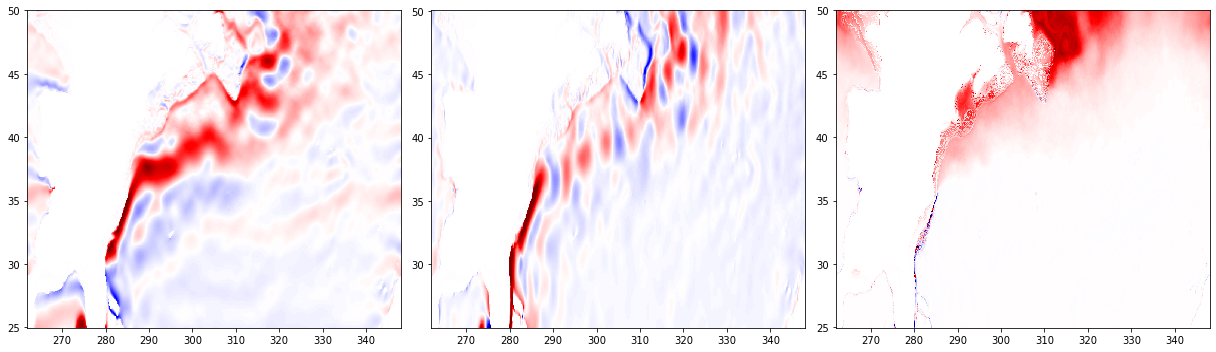

In [27]:
fig, axes = plt.subplots(figsize=(17,5), nrows=1, ncols=3)
fig.set_tight_layout(True)

im = axes[0].pcolormesh(uhat.XG, uhat.YC.sel(YC=slice(ystart,yend+12**-1)), 
                        uhat.sel(YC=slice(ystart,yend+12**-1)).isel(deltax_outer=23), 
                        vmax=5e-1, vmin=-5e-1, 
                        cmap='seismic', rasterized=True, shading='auto')
axes[1].pcolormesh(vhat.XC, vhat.YG.sel(YG=slice(ystart,yend+12**-1)), 
                   vhat.sel(YG=slice(ystart,yend+12**-1)).isel(deltay_outer=23), 
                   vmax=5e-1, vmin=-5e-1,
                   cmap='seismic', rasterized=True, shading='auto')
axes[2].pcolormesh(varpihat.XC, varpihat.YC.sel(YC=slice(ystart,yend+12**-1)), 
                   varpihat.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                   vmax=1e-8, vmin=-1e-8,
                   cmap='seismic', rasterized=True, shading='auto')

plt.show()

In [28]:
imemb = 0
ds5 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/dZb/' 
                           % (imemb))
                  )
ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/' 
                           % (imemb))
                  )

yystart = 0
yy = yystart

for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                               % (imemb,year)))
    
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)

###############################
    dzetaFp = ds2.dzetaF - ds5.dzetab
    dzetaFxp = ds2.dzetaFx - ds5.dzetaxb
    dzetaFyp = ds2.dzetaFy - ds5.dzetayb


    zetap = (ds2.zdz*ds2.dzetaF**-1) - ds7.zetab
    zetaxp = (ds2.zxdz*ds2.dzetaFx**-1) - ds7.zetaxb
    zetayp = (ds2.zydz*ds2.dzetaFy**-1) - ds7.zetayb

###############################
    dsave = dzetaFp.to_dataset(name='dzetap')
    dsave['dzetaxp'] = dzetaFxp
    dsave['dzetayp'] = dzetaFyp
    dsave['zetap'] = zetap
    dsave['zetaxp'] = zetaxp
    dsave['zetayp'] = zetayp
    dsave.coords['delta'] = ('delta',delta)
    if len(dsave.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
    if yy == yystart:
        print(dsave)
    print(year)
    dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d' 
                                                  % (imemb,year)), mode='w')
    yy += 1
    dsave.close()
    ds2.close()
    
ds5.close()
ds7.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * time          (time) timedelta64[ns] 1830 days 1835 days ... 2190 days
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta         (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    dzetap        (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 200, 5), meta=np.ndarray>
    dzeta

In [9]:
imemb = 0
ds5 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann/' 
                           % (imemb))
                  )

yystart = 48
yy = yystart

for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data
               )

    dzetaFp = ds2.dzetaF - ds5.dzetab
    dzetaFxp = ds2.dzetaFx - ds5.dzetaxb
    dzetaFyp = ds2.dzetaFy - ds5.dzetayb

###############################
    dsave = dzetaFp.to_dataset(name='dzetap')
    dsave['dzetaxp'] = dzetaFxp
    dsave['dzetayp'] = dzetaFyp
    dsave.coords['delta'] = ('delta',delta)
    if len(dsave.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
    if yy == yystart:
        print(dsave)
    dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/dZps/ann/run%4d' 
                                                  % (imemb,year)), mode='w')
    dsave.close()
    ds2.close()
    print(year)
    yy += 1
    
ds5.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * time          (time) timedelta64[ns] 19350 days 19355 days ... 19710 days
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta         (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    dzetap        (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    dz

In [28]:
imemb = 0
ds5 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann/' 
                           % (imemb))
                  )

yystart = 47
yy = yystart

for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)

    
    zetap = (ds2.zdz*ds2.dzetaF**-1) - ds5.zetab
    zetaxp = (ds2.zxdz*ds2.dzetaFx**-1) - ds5.zetaxb
    zetayp = (ds2.zydz*ds2.dzetaFy**-1) - ds5.zetayb

###############################
    dsave = zetap.to_dataset(name='zetap')
    dsave['zetaxp'] = zetaxp
    dsave['zetayp'] = zetayp
    dsave.coords['delta'] = ('delta',delta)
    if len(dsave.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
    if yy == yystart:
        print(dsave)
    dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d' 
                                                  % (imemb,year)), mode='w')
    dsave.close()
    ds2.close()
    print(year)
    yy += 1
    
ds5.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * time          (time) timedelta64[ns] 18985 days 18990 days ... 19345 days
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta         (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    zetap         (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    ze

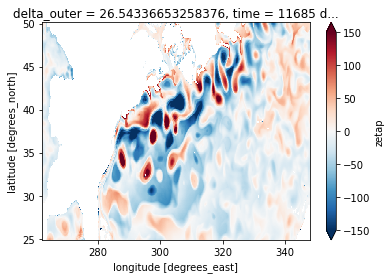

In [29]:
xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d' 
                     % (0,1990))
            ).zetap.isel(time=0,delta_outer=23).plot(vmin=-1.5e2, vmax=1.5e2, cmap='RdBu_r')

In [8]:
imemb = 0

ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynb/ann' 
                           % (imemb))
                  )

yystart = 49
yy = yystart
for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    ds4 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)

###############################
    vpp = ds3.vdz*ds2.dzetaFy**-1 - ds8.vhat
    upp = ds3.udz*ds2.dzetaFx**-1 - ds8.uhat
    varpidz = ds4.diadz + ds4.cmpdz
    varpipp = varpidz*ds2.dzetaF**-1 - ds8.varpihat
        
###############################
    dsave = upp.to_dataset(name='upp')
    dsave['vpp'] = vpp
    dsave['varpipp'] = varpipp
    dsave.coords['delta'] = ('delta',delta)
    if len(dsave.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
    dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d' 
                                                  % (imemb,year)), mode='w')
    if yy == yystart:
        print(dsave)
    print(year)
    yy += 1
    dsave.close()
    ds2.close()
    ds3.close()
    ds4.close()

ds8.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * time          (time) timedelta64[ns] 19715 days 19720 days ... 20075 days
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta         (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    upp           (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    v

In [8]:
imemb = 0

ds9 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pb/ann' 
                           % (imemb))
                  )

yystart = 47
yy = yystart
for year in years[yystart:]:
    
    ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    ds3 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns_rechunked/run%4d/' 
                               % (imemb,year))
                      )
    
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data
               )
    
###############################
    mbx = ds3.pxdz * ds2.dzetaFx**-1
    mby = ds3.pydz * ds2.dzetaFy**-1
    mbxp = mbx - ds9.mbxb
    mbyp = mby - ds9.mbyb
        
###############################
    dsave = mbxp.to_dataset(name='mbxp')
    dsave['mbyp'] = mbyp
    dsave.coords['delta'] = ('delta',delta)
    if len(dsave.time) == 73:
        pass
    else:
        print("ERROR!!!!!")
        break
    dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d' 
                                                  % (imemb,year)), mode='w')
    if yy == yystart:
        print(dsave)
    print(year)
    yy += 1
    dsave.close()
    ds2.close()
    ds3.close()

ds9.close()

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * time          (time) timedelta64[ns] 18985 days 18990 days ... 19345 days
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG            (YG) float64 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta         (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    mbxp          (time, YC, XG, deltax_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    mbyp          (time, YG, XC, deltay_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=